In [6]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [7]:
dataset = MNIST(root="data", download=True)
len(dataset)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 601kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.62MB/s]


60000

In [8]:
test_dataset = MNIST(root="data/", train=False)
len(test_dataset)

10000

In [9]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

Label: 5


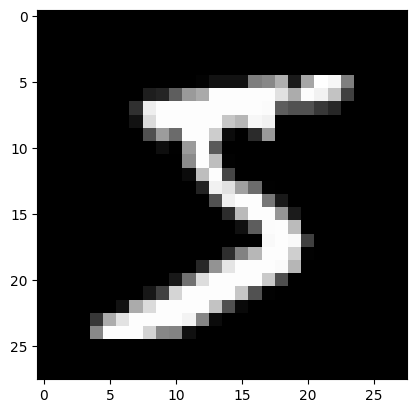

In [11]:
%matplotlib inline
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print(f'Label: {label}')

In [13]:
dataset = MNIST(root="data", train=True, transform=ToTensor())

In [14]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [15]:
print(img_tensor.min(), img_tensor.max())

tensor(0.) tensor(1.)


In [16]:
print(img_tensor[0:, 10:15, 10:15])

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


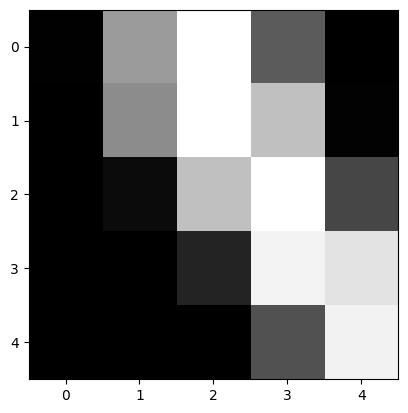

In [18]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.functional import F

In [22]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [24]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [26]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
      #training phase
      for batch in train_dl:
        loss = model.training_step(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      #validation phase
      result = evaluate(model, val_dl)
      model.epoch_end(epoch, result)
      history.append(result)
    return history

def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [28]:
input_size = 784
num_classes = 10
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)
  def forward(self, xb):
    xb=xb.reshape(-1, 784)
    out=self.linear(xb)
    return out
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    #_, preds = torch.max(out, dim=1)
    #acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return  {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [29]:
result0 = evaluate(model, val_dl)
result0

{'val_loss': 2.2945852279663086, 'val_acc': 0.13192246854305267}

In [30]:
history1 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.9354, val_acc: 0.6454
Epoch [1], val_loss: 1.6716, val_acc: 0.7365
Epoch [2], val_loss: 1.4745, val_acc: 0.7639
Epoch [3], val_loss: 1.3256, val_acc: 0.7816
Epoch [4], val_loss: 1.2110, val_acc: 0.7938


In [31]:
history2 = fit(5, 0.01, model, train_dl, val_dl)
history2

Epoch [0], val_loss: 0.7579, val_acc: 0.8390
Epoch [1], val_loss: 0.6247, val_acc: 0.8547
Epoch [2], val_loss: 0.5586, val_acc: 0.8626
Epoch [3], val_loss: 0.5173, val_acc: 0.8683
Epoch [4], val_loss: 0.4890, val_acc: 0.8736


[{'val_loss': 0.7578553557395935, 'val_acc': 0.8390031456947327},
 {'val_loss': 0.6247417330741882, 'val_acc': 0.854727029800415},
 {'val_loss': 0.5585772395133972, 'val_acc': 0.8626384735107422},
 {'val_loss': 0.5172519683837891, 'val_acc': 0.8682753443717957},
 {'val_loss': 0.48898741602897644, 'val_acc': 0.8736155033111572}]

Label: 7


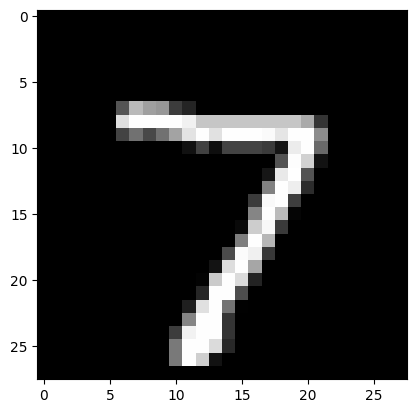

In [32]:
test_dataset = MNIST(root="data/", train=False, transform=ToTensor())
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label)


Label: 2 , Predicted: 8


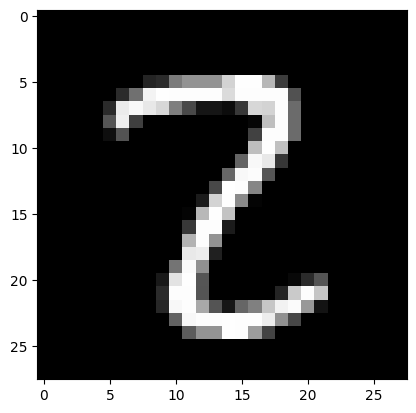

In [36]:
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [37]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.45471230149269104, 'val_acc': 0.887402355670929}

In [38]:
torch.save(model.state_dict(), 'mnist-logistic.pth')